In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Pré-pocessamento
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import Counter

from sklearn.model_selection import GridSearchCV,  RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate 

# Classificadores
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#Métricas
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.inspection import permutation_importance
from mlxtend.plotting import plot_decision_regions

In [2]:
df = pd.read_csv('data/classification_train.csv',  encoding='UTF-8',sep=',')
df.head()

,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


In [3]:
df.describe()

,x1,x2,target
count,670.000000,670.000000,670.000000
mean,0.481824,0.262611,0.505970
std,0.914772,0.615023,0.500338
min,-1.939767,-1.313970,0.000000
25%,-0.169615,-0.159189,0.000000
50%,0.492489,0.275538,1.000000
75%,1.159680,0.717589,1.000000
max,2.590410,1.904169,1.000000


In [7]:
X = df.drop(['target'],axis=1)
y = df['target'].to_numpy().ravel()

<ipython-input-6-f4e00ea6ab9e>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  X.hist(ax=ax)


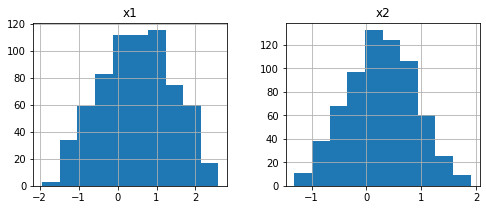

In [6]:
fig = plt.figure(figsize = (8,3))
ax = fig.gca()
X.hist(ax=ax)
plt.show()

In [8]:
np.any(df.isnull().sum())

False

In [9]:
X = df.drop(['target'],axis=1)
y = df['target'].to_numpy().ravel()
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      670 non-null    float64
 1   x2      670 non-null    float64
dtypes: float64(2)
memory usage: 10.6 KB


In [10]:
print("Volumetria das observações por classe:\n", Counter(y))

Volumetria das observações por classe:
 Counter({1: 339, 0: 331})


In [11]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,x1,x2
x1,1.00,-0.34
x2,-0.34,1.00


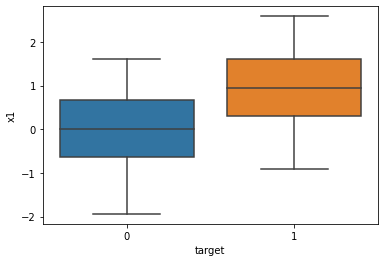

In [12]:
ax = sns.boxplot(x='target', y='x1', data=df, orient="v")

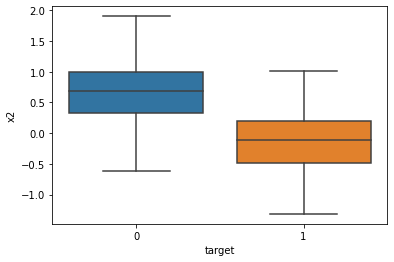

In [13]:
ax = sns.boxplot(x='target', y='x2', data=df, orient="v")

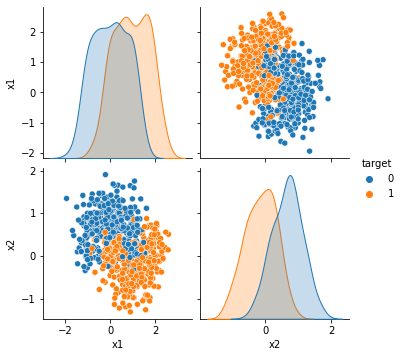

In [14]:
sns.pairplot(df, hue='target', height=2.5)

In [15]:
df_test = pd.read_csv('data/classification_test.csv',  encoding='UTF-8',sep=',')

In [16]:
X_test = df_test.drop(['target'],axis=1)
y_test = df_test['target'].to_numpy().ravel()

In [25]:
# Aplica a padronização no conjunto treino
X_stand = StandardScaler().fit_transform(X)

# Aplica a padronização no conjunto teste
X_test = StandardScaler().fit_transform(X_test)

In [17]:
lr = LogisticRegression(random_state=4, n_jobs=-1, warm_start=True)
rf = RandomForestClassifier(random_state=4, n_jobs=-1, max_features="auto", warm_start=True)
gb = GradientBoostingClassifier(random_state=4, subsample=0.8, max_features="auto", warm_start=True)
svc = SVC(random_state=4)

In [18]:
clf_list = [lr, rf, gb, svc]

In [19]:
alphas = [0.1,0.3,0.5,0.7,0.9,1]
solvers = ['lbfgs', 'liblinear', 'saga'] # Regressao logistica
kernels = ['poly', 'rbf', 'sigmoid', ]
C_s = [0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.9, 1, 3, 5]


param_lr = {'C': alphas, 'solver': solvers}

param_rf = {"criterion":["gini", "entropy"],"max_depth": range(5,20,5), 
         "min_samples_leaf": range(2,10,2), "n_estimators":range(100,1000,200)}  # rf

param_gb = {"learning_rate":[0.001,0.01,0.1], "n_estimators":range(200,1000,200)}  #gb   

param_svc = {"C":C_s, "kernel":["rbf", "poly", "sigmoid"], "gamma": ["auto", "scale"], "degree":range(1,10,1)} 

In [20]:
parameters_list = [param_lr, param_rf, param_gb, param_svc]

In [21]:
model_log = ["_lr", "_rf", "_gb", "_svc"]

In [22]:
gs_best_params_clf = {}
gs_best_score_clf = {}
gs_best_estimator_clf ={}


In [26]:
for i in range(len(clf_list)):
    grid=GridSearchCV(estimator=clf_list[i], 
                      param_grid=parameters_list[i], 
                      n_jobs=-1,
                      scoring = make_scorer(fbeta_score, beta=2),
                      cv=10, 
                      refit='F1_score',
                      verbose=2).fit(X_stand, y)
    
    gs_best_params_clf[f'Grid_{model_log[i]}'] = grid.best_params_
    gs_best_score_clf[f'Grid_{model_log[i]}'] = grid.best_score_
    gs_best_estimator_clf[f'Grid_{model_log[i]}'] = grid.best_estimator_

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 169 out of 180 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 377 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1025 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  6.7min finished
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 con

In [27]:
print(gs_best_params_clf)

{'Grid__lr': {'C': 0.1, 'solver': 'lbfgs'}, 'Grid__rf': {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 700}, 'Grid__gb': {'learning_rate': 0.001, 'n_estimators': 800}, 'Grid__svc': {'C': 5, 'degree': 9, 'gamma': 'auto', 'kernel': 'poly'}}


In [28]:
print(gs_best_score_clf)

{'Grid__lr': 0.8410898678724894, 'Grid__rf': 0.9034074116480063, 'Grid__gb': 0.9116863288068613, 'Grid__svc': 0.9104191789695696}


In [29]:
gs_best_estimator_clf

{'Grid__lr': LogisticRegression(C=0.1, n_jobs=-1, random_state=4, warm_start=True),
 'Grid__rf': RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,
                        n_estimators=700, n_jobs=-1, random_state=4,
                        warm_start=True),
 'Grid__gb': GradientBoostingClassifier(learning_rate=0.001, max_features='auto',
                            n_estimators=800, random_state=4, subsample=0.8,
                            warm_start=True),
 'Grid__svc': SVC(C=5, degree=9, gamma='auto', kernel='poly', random_state=4)}

Treinamento dos classificadores com os parâmetros selecionados

In [30]:
# Regressão logistica
lr = LogisticRegression(C=gs_best_params_clf['Grid__lr']['C'],
                        solver=gs_best_params_clf['Grid__lr']['solver'],
                        n_jobs=-1, 
                        random_state=4,
                        warm_start=True) 

# Random forest
rf = RandomForestClassifier(criterion=gs_best_params_clf['Grid__rf']['criterion'],
                            max_depth=gs_best_params_clf['Grid__rf']['max_depth'],
                            min_samples_leaf=gs_best_params_clf['Grid__rf']['min_samples_leaf'],
                            n_estimators=gs_best_params_clf['Grid__rf']['n_estimators'],
                            random_state=4, n_jobs=-1, max_features="auto", warm_start=True)

# gradient boosting
gb = GradientBoostingClassifier(learning_rate=gs_best_params_clf['Grid__gb']['learning_rate'],
                                n_estimators=gs_best_params_clf['Grid__gb']['n_estimators'],
                                random_state=4,
                                subsample=0.8, 
                                max_features="auto", 
                                warm_start=True)
#svc
svc = SVC(C=gs_best_params_clf['Grid__svc']['C'],
          degree=gs_best_params_clf['Grid__svc']['degree'],
          gamma=gs_best_params_clf['Grid__svc']['gamma'],
          kernel=gs_best_params_clf['Grid__svc']['kernel'],
          random_state=4)

In [31]:
model_lr = lr.fit(X_stand, y)
model_rf = rf.fit(X_stand, y)
model_gb = gb.fit(X_stand, y)
model_svc = svc.fit(X_stand, y)

Regressão logística:

    Acurácia 0.837
    Recall 0.835
    Precisão 0.842
    F1-Score 0.839
    F2-Score 0.836

Support vector machine para classificação:

    Acurácia 0.845
    Recall 0.947
    Precisão 0.789
    F1-Score 0.861
    F2-Score 0.910 OBS: O SVM obteve resultados superiores a regressão logística, salvo com relação a precisão.

Random Forest

    Acurácia 0.896
    Recall 0.935
    Precisão 0.868
    F1-Score 0.901
    F2-Score 0.921

Gradient Boosting

    Acurácia 0.879
    Recall 0.944
    Precisão 0.838
    F1-Score 0.888
    F2-Score 0.921


Coeficientes Modelo Regressão
Intercepto 0.065
Coeficientes  [[ 0.91791765 -1.69060939]]

Acurácia 0.837
Recall 0.838
Precisão 0.840
F1-Score 0.839
F2-Score 0.838


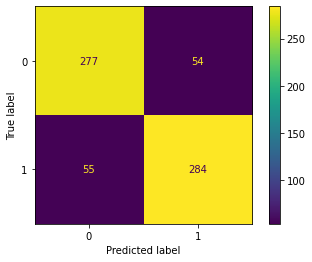

In [33]:
y_pred_lr = model_lr.predict(X_stand)

print("Coeficientes Modelo Regressão")
print("Intercepto %.3f" % (model_lr.intercept_))
print("Coeficientes ", model_lr.coef_)

print("\nAcurácia %.3f" % (accuracy_score(y,y_pred_lr)))
print("Recall %.3f" % (recall_score(y,y_pred_lr)))
print("Precisão %.3f" % (precision_score(y,y_pred_lr)))
print("F1-Score %.3f" % (f1_score(y,y_pred_lr)))
print("F2-Score %.3f" % (fbeta_score(y, y_pred_lr, beta=2)))

cm = confusion_matrix(y, y_pred_lr, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm).plot()

Acurácia 0.896
Recall 0.935
Precisão 0.868
F1-Score 0.901
F2-Score 0.921


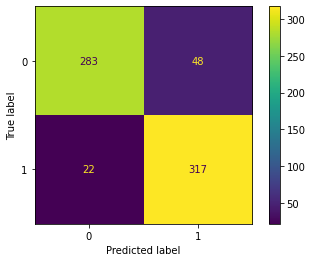

In [34]:
y_pred_rf = model_rf.predict(X_stand)

print("Acurácia %.3f" % (accuracy_score(y,y_pred_rf)))
print("Recall %.3f" % (recall_score(y,y_pred_rf)))
print("Precisão %.3f" % (precision_score(y,y_pred_rf)))
print("F1-Score %.3f" % (f1_score(y,y_pred_rf)))
print("F2-Score %.3f" % (fbeta_score(y, y_pred_rf, beta=2)))

cm = confusion_matrix(y, y_pred_rf, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm).plot()

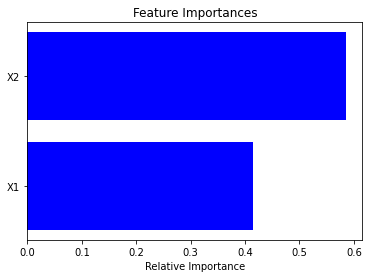

In [35]:
features = ['X1','X2']
importances = model_rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Acurácia 0.881
Recall 0.944
Precisão 0.840
F1-Score 0.889
F2-Score 0.921


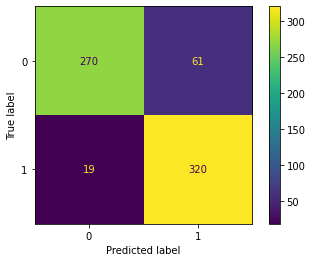

In [36]:
y_pred_gb = model_gb.predict(X_stand)

print("Acurácia %.3f" % (accuracy_score(y,y_pred_gb)))
print("Recall %.3f" % (recall_score(y,y_pred_gb)))
print("Precisão %.3f" % (precision_score(y,y_pred_gb)))
print("F1-Score %.3f" % (f1_score(y,y_pred_gb)))
print("F2-Score %.3f" % (fbeta_score(y, y_pred_gb, beta=2)))

cm = confusion_matrix(y, y_pred_gb, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm).plot()


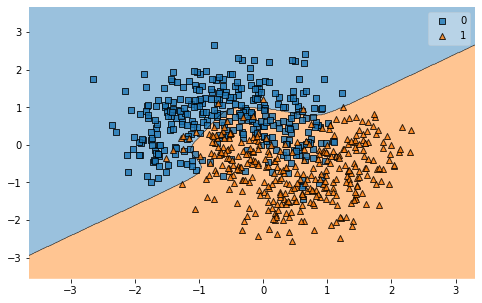

In [40]:
plt.figure(figsize=(8, 5))
plot_decision_regions(X_stand, y, clf=model_svc)

plt.show()

Acurácia 0.799
Recall 0.971
Precisão 0.725
F1-Score 0.830
F2-Score 0.909


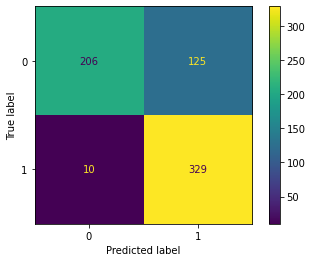

In [41]:
y_pred_svc = model_svc.predict(X_stand)

print("Acurácia %.3f" % (accuracy_score(y,y_pred_svc)))
print("Recall %.3f" % (recall_score(y,y_pred_svc)))
print("Precisão %.3f" % (precision_score(y,y_pred_svc)))
print("F1-Score %.3f" % (f1_score(y,y_pred_svc)))
print("F2-Score %.3f" % (fbeta_score(y, y_pred_svc, beta=2)))

cm = confusion_matrix(y, y_pred_svc, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm).plot()

Resultados no Conjunto de Teste:

Regressão Logística

    Acurácia 0.839
    Recall 0.876
    Precisão 0.810
    F1-Score 0.842
    F2-Score 0.862
    AUC precisao-recall 0.91

SVC

    Acurácia 0.791
    Recall 0.938
    Precisão 0.719
    F1-Score 0.814
    F2-Score 0.884
    AUC precisao-recall 0.93

Random Forest

    Acurácia 0.842
    Recall 0.882
    Precisão 0.811
    F1-Score 0.845
    F2-Score 0.867
    AUC precisao-recall 0.94

Gradient Boosting

    Acurácia 0.836
    Recall 0.907
    Precisão 0.789
    F1-Score 0.844
    F2-Score 0.881
    AUC precisao-recall 0.93



Acurácia 0.830
Recall 0.851
Precisão 0.811
F1-Score 0.830
F2-Score 0.843


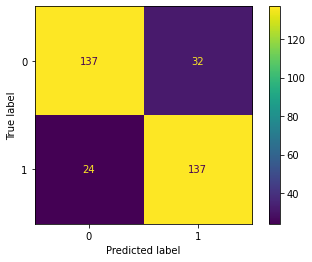

In [42]:
y_test_pred_lr = model_lr.predict(X_test)

print("Acurácia %.3f" % (accuracy_score(y_test,y_test_pred_lr)))
print("Recall %.3f" % (recall_score(y_test,y_test_pred_lr)))
print("Precisão %.3f" % (precision_score(y_test,y_test_pred_lr)))
print("F1-Score %.3f" % (f1_score(y_test,y_test_pred_lr)))
print("F2-Score %.3f" % (fbeta_score(y_test, y_test_pred_lr, beta=2)))

cm = confusion_matrix(y_test, y_test_pred_lr, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm).plot()

AUC Precision Recall 0.916


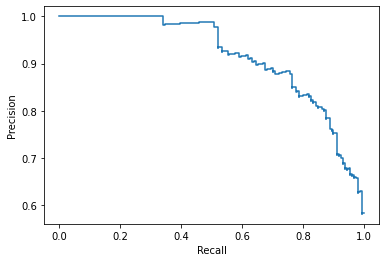

In [43]:
y_score_lr = model_lr.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score_lr, pos_label=lr.classes_[1])
pr_display2 = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

print("AUC Precision Recall %.3f" % (auc(recall, prec)))

Acurácia 0.861
Recall 0.907
Precisão 0.825
F1-Score 0.864
F2-Score 0.889


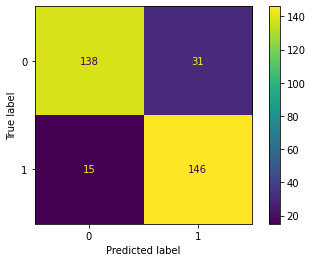

In [44]:
y_test_pred_rf = model_rf.predict(X_test)

print("Acurácia %.3f" % (accuracy_score(y_test,y_test_pred_rf)))
print("Recall %.3f" % (recall_score(y_test,y_test_pred_rf)))
print("Precisão %.3f" % (precision_score(y_test,y_test_pred_rf)))
print("F1-Score %.3f" % (f1_score(y_test,y_test_pred_rf)))
print("F2-Score %.3f" % (fbeta_score(y_test, y_test_pred_rf, beta=2)))

cm = confusion_matrix(y_test, y_test_pred_rf, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm).plot()


AUC Precision Recall 0.939


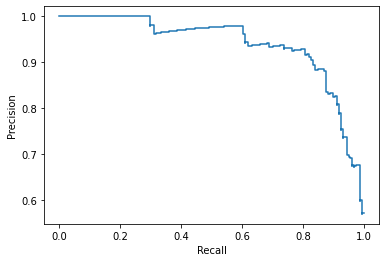

In [45]:
y_score_rf = model_rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_score_rf = y_score_rf[:, 1]
prec, recall, _ = precision_recall_curve(y_test, y_score_rf, pos_label=lr.classes_[1])
pr_display2 = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

print("AUC Precision Recall %.3f" % (auc(recall, prec)))

Acurácia 0.845
Recall 0.913
Precisão 0.799
F1-Score 0.852
F2-Score 0.888


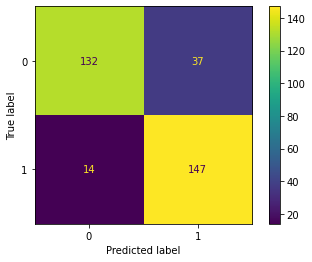

In [46]:
y_test_pred_gb = model_gb.predict(X_test)

print("Acurácia %.3f" % (accuracy_score(y_test,y_test_pred_gb)))
print("Recall %.3f" % (recall_score(y_test,y_test_pred_gb)))
print("Precisão %.3f" % (precision_score(y_test,y_test_pred_gb)))
print("F1-Score %.3f" % (f1_score(y_test,y_test_pred_gb)))
print("F2-Score %.3f" % (fbeta_score(y_test, y_test_pred_gb, beta=2)))

cm = confusion_matrix(y_test, y_test_pred_gb, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm).plot()

AUC Precision Recall 0.927


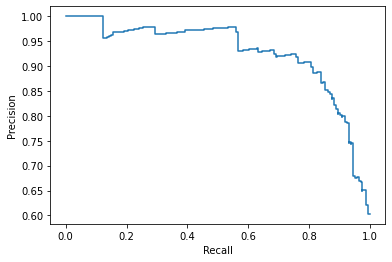

In [47]:
y_score_gb = model_gb.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_score_gb = y_score_gb[:, 1]
prec, recall, _ = precision_recall_curve(y_test, y_score_gb, pos_label=lr.classes_[1])
pr_display2 = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

print("AUC Precision Recall %.3f" % (auc(recall, prec)))

Acurácia 0.809
Recall 0.981
Precisão 0.725
F1-Score 0.834
F2-Score 0.916


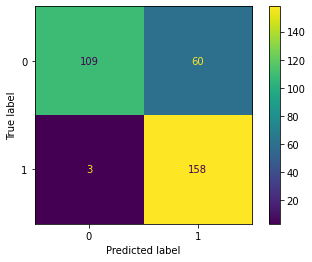

In [48]:
y_test_pred_svc = model_svc.predict(X_test)

print("Acurácia %.3f" % (accuracy_score(y_test,y_test_pred_svc)))
print("Recall %.3f" % (recall_score(y_test,y_test_pred_svc)))
print("Precisão %.3f" % (precision_score(y_test,y_test_pred_svc)))
print("F1-Score %.3f" % (f1_score(y_test,y_test_pred_svc)))
print("F2-Score %.3f" % (fbeta_score(y_test, y_test_pred_svc, beta=2)))

cm = confusion_matrix(y_test, y_test_pred_svc, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm).plot()

AUC Precision Recall 0.925


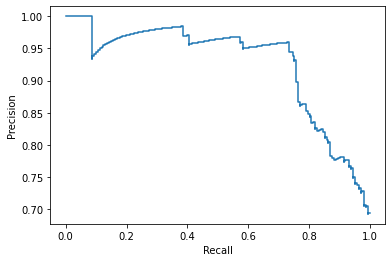

In [49]:
y_score_svc = model_svc.decision_function(X_test)
prec, recall, _ = precision_recall_curve(y_test, y_score_svc, pos_label=lr.classes_[1])
pr_display2 = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

print("AUC Precision Recall %.3f" % (auc(recall, prec)))